In [1]:
import numpy as np
import scipy
import scipy.signal
import scipy.fftpack

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline

In [ ]:
# run cell for interactive plots
import mpld3
mpld3.enable_notebook()

In [2]:
# impulse response log files
logs = [
    'implresp_v5.pb.cobs.gz',
    'implresp_v6.pb.cobs.gz',
    'implresp_v7.pb.cobs.gz',
]

# impulse response log files using
# 5 element moving average filter
logs_ma5 = [
    'implresp_v5_ma5.pb.cobs.gz',
    'implresp_v6_ma5.pb.cobs.gz',
    'implresp_v7_ma5.pb.cobs.gz',
]

In [3]:
%%javascript 
var kernel = Jupyter.notebook.kernel; 
var command = ["notebookName = ",
               "'", window.document.body.dataset.notebookName, "'" ].join('')
kernel.execute(command)

<IPython.core.display.Javascript object>

In [4]:
import os
import sys
file_dir = os.path.dirname(os.path.abspath(notebookName))
sys.path.append(os.path.abspath(os.path.join(file_dir, os.pardir)))
from plot_sim import plot_states
from load_sim import load_messages, get_records_from_messages, get_time_vector
from simulate_whipple_benchmark import simulate

In [5]:
records = []
for logname in logs:
    msg = load_messages(os.path.join(file_dir, logname))
    # ignore first sample as it is transmitted before the simulation loop
    data = get_records_from_messages(msg[1:])
    rec = dict()
    rec['data'] = data
    rec['metadata'] = msg[0]
    records.append(rec)

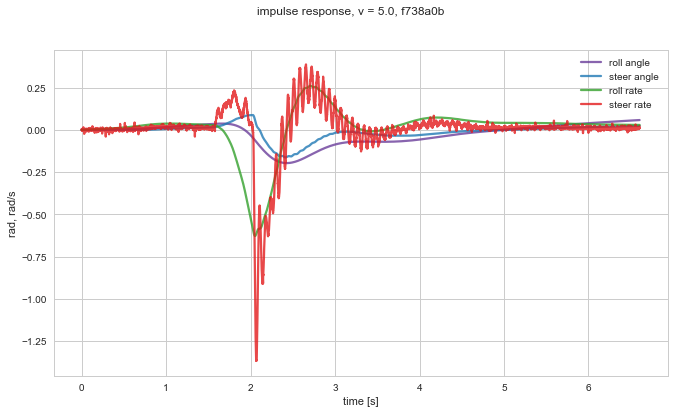

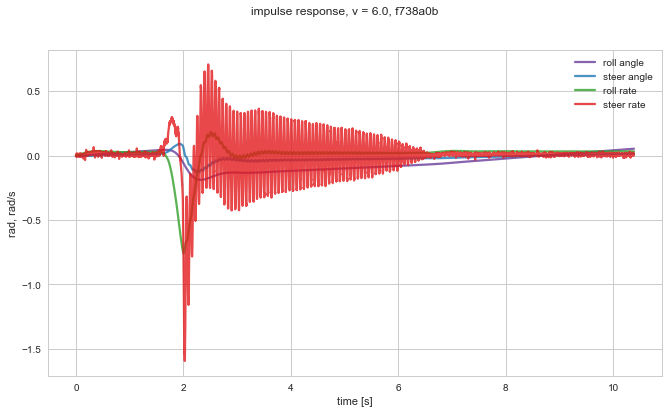

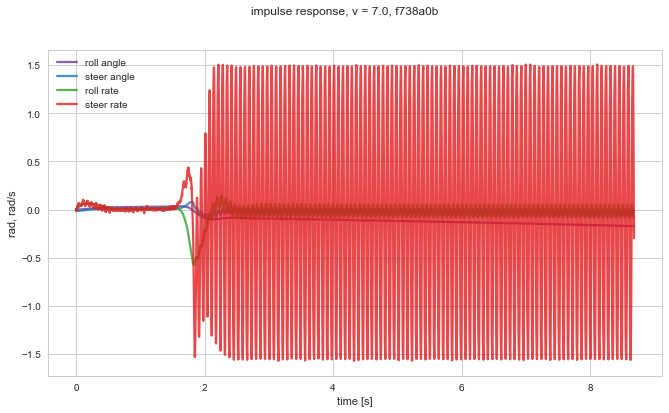

In [6]:
for rec in records:
    data = rec['data']
    m = rec['metadata']
    # redefine zero time
    t = get_time_vector(data)
    t -= t[0]
    rec['time'] = t
        
    fig, ax = plot_states(t, data.state[:, 1:],
                          second_yaxis=False, to_degrees=False)
    fig.set_size_inches(11, 6)
    
    try:
        title = 'impulse response, v = {}, {}'.format(
            m.model.v, m.gitsha1.f.decode())
        mpld3
    except NameError:
        fig.suptitle(title)
    else:
        ax.set_title(title)

In [7]:
def fft(x, sample_period, window_type=None):
    """ Calculate the Fourier transform for signal x. Input is assumed real and
    the first half of the frequencies and amplitudes are returned. window_type
    specifies the windowing function used, hamming is default.
    """
    if window_type is None:
        window_type = scipy.signal.hamming
    n = len(x)
    windowed_x = np.multiply(x, window_type(n))

    # only use first half of fft since real signals are mirrored about nyquist
    # frequency
    xf = 2/n * np.abs(scipy.fftpack.fft(windowed_x)[:n//2])
    freq = np.linspace(0, 1/(2*sample_period), n//2)
    return freq, xf

In [8]:
def roi_index(rec):
    steer_rate = rec['data'].state[:, 4]
    std = steer_rate.std()
    abs_rate = np.abs(steer_rate)
    ind_std = np.argwhere(abs_rate > 1*std)
    try:
        # this occurs for response decays after impulse
        i = np.argwhere(abs_rate > 2*std)[0][0]
    except IndexError:
        # use single standard dev for region of interest
        i = ind_std[0][0]
        j = ind_std[-1][0]
    else:
        # find index of max value
        i = np.argmax(abs_rate)
        j = np.argwhere(abs_rate > 0.2*std)[-1][0]
    #print('impulse after {} seconds, until {} seconds'.format(
    #    rec['time'][i], rec['time'][j]))
    return i, j

In [9]:
def plot_fft(states, dt, xlim=None):
    labels = [
        'roll angle',
        'steer angle',
        'roll rate',
        'steer rate',
    ]
    colors = np.roll(sns.color_palette('Paired', 10), 2, axis=0)
    
    xf = []
    for s in range(len(labels)):
        freq, xfs = fft(states[:, s], m.model.dt)
        xf.append(xfs)
    
    try:
        i = np.argwhere(freq < xlim[0])[-1][0]
    except:
        i = 0
    try:
        j = np.argwhere(freq > xlim[1])[0][0]
    except:
        j = -1
    fig, ax = plt.subplots()
    for s in range(len(labels)):
        ax.plot(freq[i:j], xf[s][i:j], color=colors[2*s + 1], label=labels[s])
    ax.set_yscale('log')
    ax.set_xlabel('frequency [Hz]')
    ax.set_ylabel('amplitude')
    ax.legend()
    return fig, ax

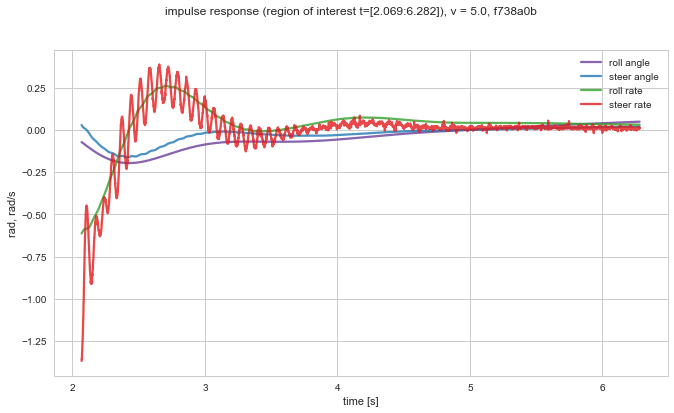

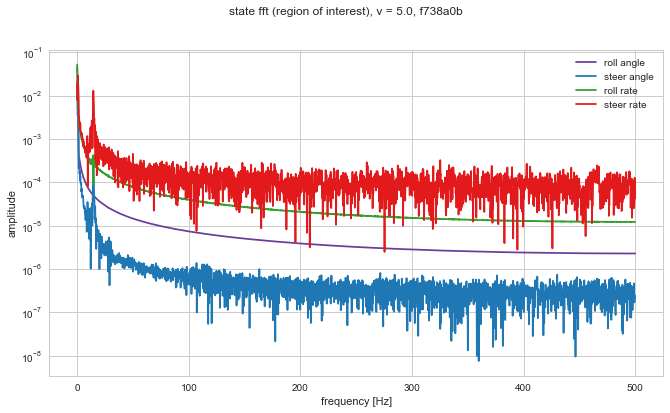

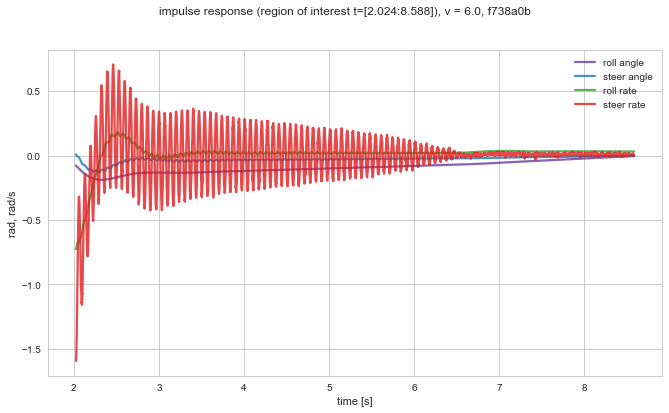

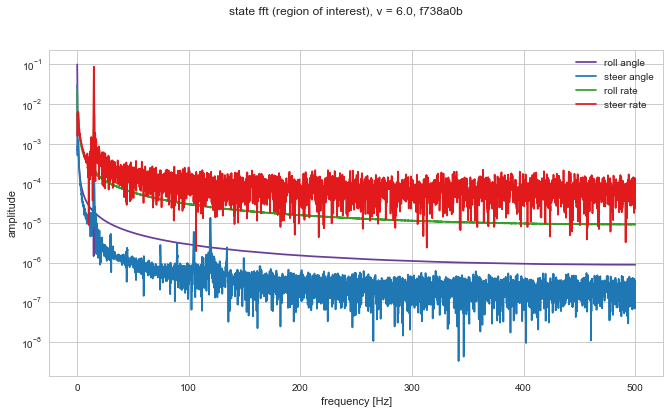

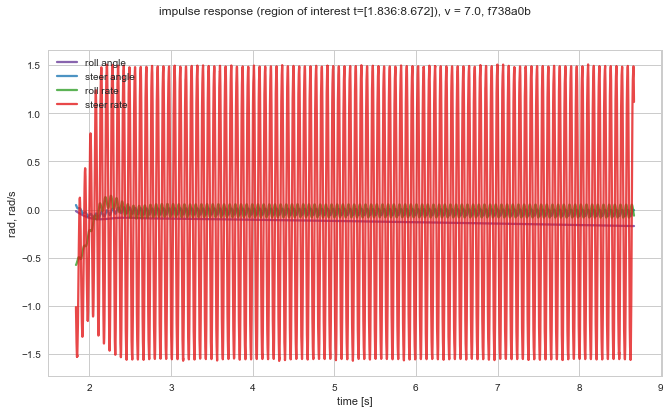

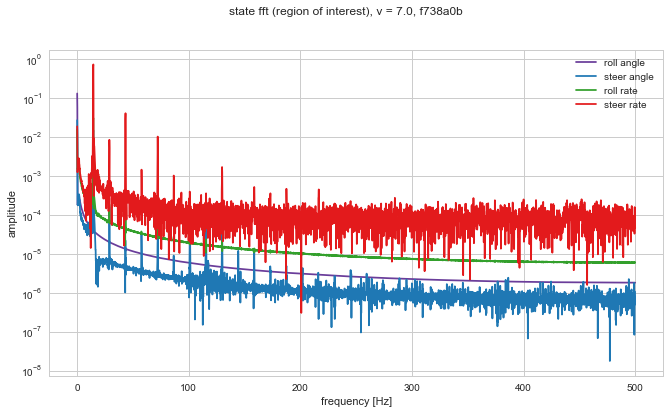

In [10]:
for rec in records:
    data = rec['data']
    m = rec['metadata']
    t = rec['time']
    i, j = roi_index(rec)
        
    fig1, ax1 = plot_states(t[i:j], data.state[i:j, 1:],
                          second_yaxis=False, to_degrees=False)
    fig1.set_size_inches(11, 6)
    try:
        title = 'impulse response (region of interest t=[{}:{}])'.format(
            t[i], t[j])
        title +=  ', v = {}, {}'.format(m.model.v, m.gitsha1.f.decode())
        mpld3
    except NameError:
        fig1.suptitle(title)
    else:
        ax1.set_title(title)
        
    fig2, ax2 = plot_fft(data.state[i:j, 1:], m.model.dt)
    fig2.set_size_inches(11, 6)
    try:
        title = 'state fft (region of interest), v = {}, {}'.format(
            m.model.v, m.gitsha1.f.decode())
        mpld3
    except NameError:
        fig2.suptitle(title)
    else:
        ax2.set_title(title)

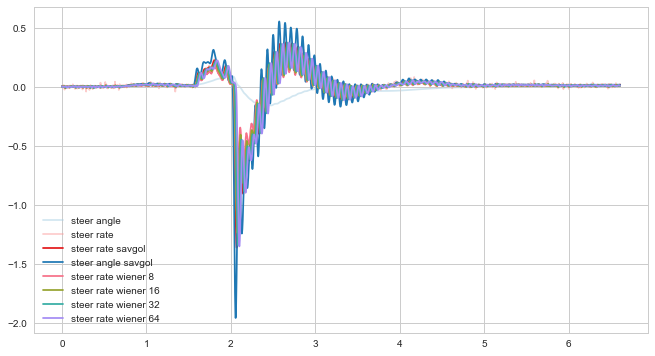

In [11]:
# compute Wiener filter for steer rate signal
# use Savitzky-Golay filtered steer rate signal for
# our assumed original signal, window length 55, order 5
rec = records[0]
states = rec['data'].state[:, 1:]
t = rec['time']
m = rec['metadata']
steer_angle = states[:, 1]
steer_rate = states[:, 3]

# get savitzky-golay filtered steer rate
steer_rate_savgol = scipy.signal.savgol_filter(steer_rate, 55, 5)
# get savitzky-golay filtered steer angle
steer_angle_savgol = scipy.signal.savgol_filter(
    steer_angle, 111, 7, deriv=1, delta=m.model.dt)

# plot savgol and measured steer rate
colors = np.roll(sns.color_palette('Paired', 10), 2, axis=0)
fig, ax = plt.subplots()
ax.plot(t, steer_angle, label='steer angle',
        color=colors[2], zorder=0, alpha=0.5)
ax.plot(t, steer_rate, label='steer rate',
        color=colors[6], zorder=0, alpha=0.5)
ax.plot(t, steer_rate_savgol, label='steer rate savgol',
        color=colors[7],  zorder=1)
ax.plot(t, steer_angle_savgol, label='steer angle savgol',
        color=colors[3],  zorder=1)

def wiener(original_signal, observed_signal, filter_length):
    s = original_signal
    x = observed_signal
    M = filter_length
    
    # estimate cross PSDs using Welch technique
    f, Pxx = scipy.signal.csd(x, x, nperseg=M)
    f, Psx = scipy.signal.csd(s, x, nperseg=M)
    # compute Wiener filter
    H = Psx/Pxx
    # shift for causal filter
    H = H* np.exp(-1j*2*np.pi/len(H)*np.arange(len(H))*(len(H)//2))
    h = np.fft.irfft(H) # Wiender FIR taps

    # apply Wiener filter to observed signal
    y = np.convolve(np.hstack((np.zeros(M - 1), x)), h, mode='valid')
    return h, y

h8, y8 = wiener(steer_rate_savgol, steer_rate, 8)
h16, y16 = wiener(steer_rate_savgol, steer_rate, 16)
h32, y32 = wiener(steer_rate_savgol, steer_rate, 32)
h64, y64 = wiener(steer_rate_savgol, steer_rate, 64)

# add to plot
husl = sns.husl_palette(4)
ax.plot(t, y8, label='steer rate wiener 8',
        color=husl[0], zorder=1)
ax.plot(t, y16, label='steer rate wiener 16',
        color=husl[1], zorder=1)
ax.plot(t, y32, label='steer rate wiener 32',
        color=husl[2], zorder=1)
ax.plot(t, y64, label='steer rate wiener 64',
        color=husl[3], zorder=1)
ax.legend()
fig.set_size_inches(11, 6)